<center><font size=6>Trend Following Strategy</font></center>
<center>Miao Yuheng, Aug 2023</center>

🤖: There are a few minor flaws; this code is based on the Huobi API, so it might not run smoothly. However, it's not a very rigorous project, so you can choose to take a quick look at the results. Thx. ❤

---

In this document, I have built a trend-following strategy and observed whether there are repeatable moving average signals in the cryptocurrency market by tuning hyperparameters. 

**Assumptions**:
1. For a specific set of time intervals, such as short-term moving average (k=5min) and long-term moving average (k=20min), they can collectively reflect the trend of the market price movement.
2. For the same market, each trader's strategy is stable in the short term. (In the short term, it can be assumed that a trader/trading algorithm will continue to trade in a similar manner.)
**Inference:**
- Due to the stability of trading strategies, the patterns of price movements in the short term will repeat. (Because the market forces are consistent.)
**Actual Process:**
1. Consider the length of moving averages as hyperparameters and construct a dual moving average trend-following strategy.
2. For the same time period, observe whether different sets of moving averages yield consistent trading returns.
    - On one hand, this reflects whether returns are robust to the hyperparameter of moving average length.
    - On the other hand, can excess returns be obtained by tuning hyperparameters?
3. For the same set of hyperparameters, observe if returns are stable across different time periods.
    - If stable, it implies that short-term market patterns are repeating in the next time period.
    - If not stable... there are many possibilities.
**Conclusion:**
1. Using sets of moving averages to reflect market price trends is unreliable, primarily due to the lack of robustness of moving averages over time.
2. For moving average strategies, it's possible to build both trend-following and trend-reversal strategies with potential for excess returns. However, accurately determining the market state is crucial.
3. For a given asset, volatility is an essential indicator in technical analysis.

***

**假设**：
1. 对于一组特定时间区间的均线，比如短均线(k=5min)长均线(k=20min),它们可以共同反馈市场价格运行的趋势。
2. 对于同一个市场，每个交易者的策略在短期内是稳定的。（在短期内可以认为，一个交易者/交易算法，会持续以相似的方式交易。）  
**推论**：
- 因为交易策略的稳定性，短期内价格的运行规律会重复。（因为市场合力是一致的。）  
**实际流程**：
1. 将均线的时间长度视为超参数，构建一个双均线的趋势跟踪策略。
2. 对于同一段时间，观察不同均线组的交易收益是否一致。
    - 一方面这反映了收益情况对于均线长度这个超参数是否鲁棒
    - 另一方面，能否通过调优超参数来获得超额收益？
3. 对于同一组超参数，观察在不同时间段收益是否稳定。
    - 若稳定，意味着短期的市场模式，在下一个时间段重复发生了
    - 若不稳定……有很多种可能。  
**结论**：
1. 以均线组来反映市场的价格趋势是不可靠的，主要是因为均线组对于时间是不具有鲁棒性的。
2. 对于均线策略，可以构建趋势跟踪于趋势反转两种不同的策略，有获得超额收益的可能性。但是判断市场状态是至关重要的。
3. 对于同一种资产而言，技术分析中，波动性是不可缺少的重要指标。

***

## Get Market data
In the new version, the program use local data. (get_market_prices, Candle_2_Dataframe are not used anymore.)

In [13]:
from huobi.client.market import MarketClient
from huobi.constant import *
from huobi.utils import *

In [14]:
import pandas as pd

In [15]:
def get_market_prices(symbol:str, interval, size:int):
    '''
    Get market data
    获取市场数据，以Dataframe形式返回
        return price_df:Dataframe
    '''
    market_client = MarketClient(init_log=True)
    list_obj = market_client.get_candlestick(symbol, interval, size)
    # LogInfo.output("---- {interval} candlestick for {symbol} ----".format(interval=interval, symbol=symbol))
    # LogInfo.output_list(list_obj)
    price_df = Candle_2_Dataframe(list_obj)  # 注意时间顺序，第一条记录是最新记录
    price_df = price_df[::-1].reset_index(drop=True)  
    return price_df


def Candle_2_Dataframe(list_obj):
    '''把奇怪的huobi格式转化为Dataframe'''
    df = pd.DataFrame({
        'open':list(map(lambda x: x.open, list_obj)),
        'close': list(map(lambda x: x.close, list_obj)),
        'high': list(map(lambda x: x.high, list_obj)),
        'low': list(map(lambda x: x.low, list_obj)),
        'vol': list(map(lambda x: x.vol, list_obj)),
        'count': list(map(lambda x: x.count, list_obj)),
        'amount': list(map(lambda x: x.amount, list_obj)),
    })
    return df

In [10]:
# Read local data from folder:data. 从本地读取价量数据
binance_price_df = pd.read_csv("./data/SOLUSDT-1m-2023-07.csv", header=None)

binance_price_df.columns = ['open_time','open','high','low','close','volume','close_time','quote_volume','count',
                    'taker_buy_volume','taker_buy_quote_volume','ignore','human_date']

price_df = binance_price_df[['open','high','low','close']]

##  Simple Backtesting（简易回测）

## Tuning Hyper Parameters 简易调超参数

In [107]:
def backtesting_k(k_1,k_2, price_df):
    '''
    For a given pair of k values as input, this function conducts backtesting within \
    the price and volume data range provided by `price_df`, and returns the final profitability of this backtest.
    对于输入的一对k值，这个函数在price_df给定的价量数据范围内进行回测，并返回这个回测的最终收益情况。
    '''
    
    if k_1 == k_2:
        return 1., 0.
    
    # 初始化features表格
    features_df = pd.DataFrame()
    features_df['close'] = price_df['close']
    if k_1 == 1:
        features_df['SMA_k_1'] = price_df['close']
    else:
        features_df['SMA_k_1'] = price_df['close'].rolling(k_1).mean()

    if k_2 == 1:  # 这里保持了k_2 与 k_1 的对称性。深层含义是反趋势交易。
        features_df['SMA_k_2'] = price_df['close']
    else:
         features_df['SMA_k_2'] = price_df['close'].rolling(k_2).mean()


    features_df['is_below_avg5_prev'] = features_df['SMA_k_1'].shift(1) < features_df['SMA_k_2'].shift(1)
    features_df['is_below_avg5_now'] = features_df['SMA_k_1'] < features_df['SMA_k_2']

    features_df = features_df.dropna()

    
    is_below_avg5_prev = features_df['is_below_avg5_prev'].values
    is_below_avg5_now = features_df['is_below_avg5_now'].values
    is_upward_trend = np.logical_and(is_below_avg5_prev, np.logical_not(is_below_avg5_now))
    is_downward_trend = np.logical_and(np.logical_not(is_below_avg5_prev), is_below_avg5_now)
    
    buy_list = features_df[['close']][is_upward_trend]
    sell_list = features_df[['close']][is_downward_trend]

    if len(sell_list) > len(buy_list):  # Keep the volume of purchases consistent
        sell_list = sell_list[1:]
    elif len(sell_list) < len(buy_list):
        buy_list = buy_list[:-1]

    assert len(buy_list) == len(sell_list)

    
    rtn_arr = (1 + (sell_list.values - buy_list.values)/ buy_list.values)
    rtn = np.cumprod(rtn_arr)[-1]
    
    return rtn, len(buy_list)

In [16]:
import numpy as np

k1_list = [1,2,3,5,10,15,20]

Here we choose k1,k2 from k1_list, for example:(k1=5, k2=10)--means buy when the k1 moving average crosses above k2, and sell when it crosses below. 

When the k1 moving average crosses above the k2 moving average, a buy signal is generated, and when it crosses below, a sell signal is generated. Another approach(k1=10, k2=5) involves constructing a completely opposite trading strategy using a different set of moving averages. Through this method, we can effectively observe whether the market is oscillating or exhibiting a consistent trend.

In [111]:
def backtesting_all_k_pairs(price_df):
    k1_list=[1, 2, 3, 4, 5, 7, 10, 11, 12, 15, 17, 19, 20]
    n = len(k1_list)
    final_rtns = np.zeros((n, n))
    buy_times = np.zeros((n, n))
    for i in range(n):
        for j in range(n):
            rtn, count_buy = backtesting_k(k1_list[i], k1_list[j], price_df)
            final_rtns[i, j] = rtn
            buy_times[i, j] = count_buy

    # 平滑，并计算最佳参数
    # final_rtns ---------- rtns_pooled
    final_rtns = (np.round(final_rtns,6)-1)*100
    rtns_pooled = (final_rtns[1:-1,1:-1] + final_rtns[0:-2,1:-1] +  final_rtns[2:,1:-1] + final_rtns[1:-1,2:] + final_rtns[1:-1,0:-2])/5

    (k1_ind , k2_ind) = np.unravel_index(np.argmax(rtns_pooled, axis=None), rtns_pooled.shape)
    best_k1 = k1_list[k1_ind]
    best_k2 = k1_list[k2_ind]
    
    return final_rtns, best_k1, best_k2


In [128]:
len(price_df)

44640

## Visualization: Examining the Time Robustness of Optimal Hyperparameters.

For each k1, k2 pair, we have an associated expected return. This way, for the same time period, all k pairs can form an expected return matrix. Here, we can directly use a heatmap to visually observe it.

对于每一组k1,k2，我们都有一个预期收益与之对应。这样对于同一个时间段，所有的k pairs可以组成一个预期收益矩阵，这里我们直接用热力图直观地观察它。

In [148]:
final_rtns_list = []
next_rtn_list = []
best_k_pairs_list = [] 

for i in range(0,35000,5000):
    temp_price = price_df.iloc[i:i+5000, :]
    final_rtns, best_k1, best_k2 = backtesting_all_k_pairs(temp_price)
    
    final_rtns_list.append(final_rtns)
    best_k_pairs_list.append((best_k1, best_k2))
    
    temp_price = price_df.iloc[i+5000:i+5500, :]
    final_rtns, best_k1, best_k2 = backtesting_all_k_pairs(temp_price)
    next_rtn_list.append(final_rtns)


We can visually observe that optimal hyperparameters exhibit significant variations across different time periods. This indicates that the hyperparameters that generated profits in the previous time period might not necessarily yield positive returns in the subsequent period. Moving average combinations do not necessarily reflect a stable market characteristic, and the profitability lacks robustness across time.

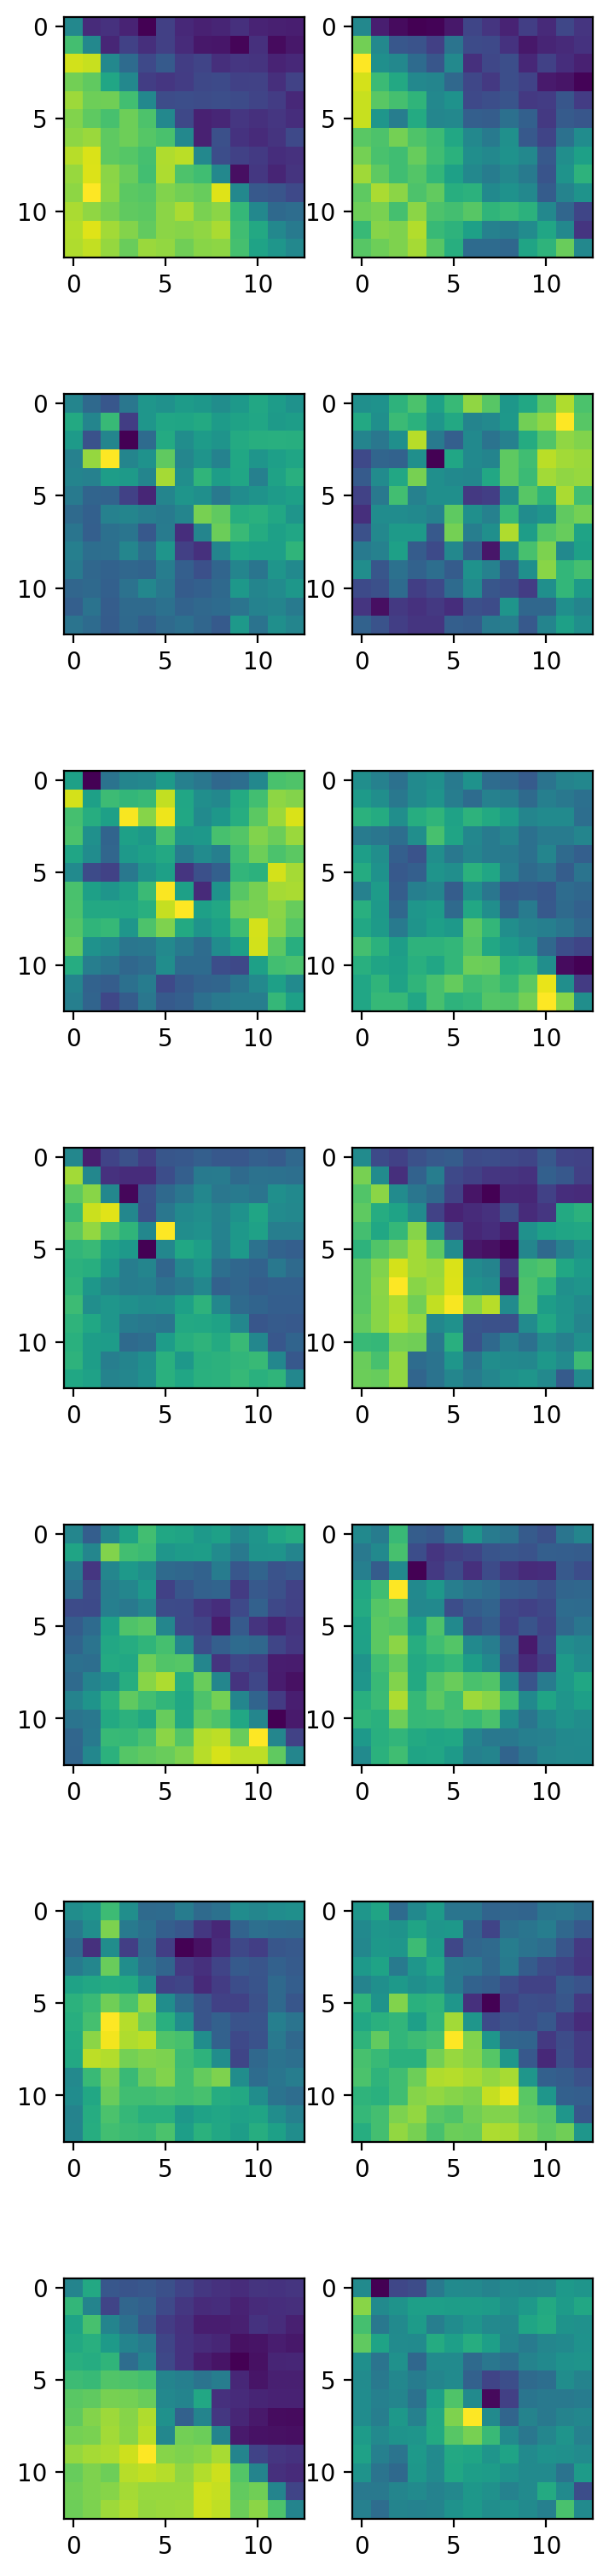

In [150]:
plt.figure(figsize=(4,20),dpi=200)
for i in range(0,len(final_rtns_list)):
    plt.subplot(7,2, 1 + 2*i)
    plt.imshow(final_rtns_list[i])
    plt.subplot(7,2, 2 + 2*i)
    plt.imshow(next_rtn_list[i])


In [92]:
import matplotlib.pyplot as plt

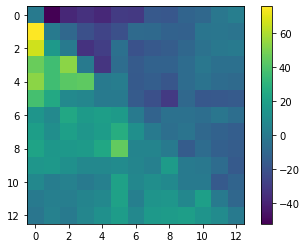

In [93]:
plt.imshow(final_rtns)
# Add colorbar
plt.colorbar()

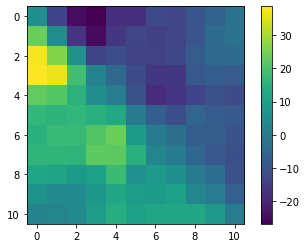

In [94]:
plt.imshow(rtns_pooled)
# Add colorbar
plt.colorbar()

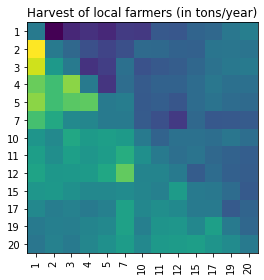

In [104]:
fig, ax = plt.subplots()
im = ax.imshow(final_rtns)

# Set tick labels
plt.xticks(range(len(k1_list)),\
           k1_list, rotation=90)
plt.yticks(range(len(k1_list)),
           k1_list)



ax.set_title("Harvest of local farmers (in tons/year)")
fig.tight_layout()
plt.show()

## 回测
查看超参数随时间变化的情况